In [ ]:
# Only for Google Collab

# Set the runtime session to a GPU/TPU session first!
# Clone the repository
!git clone https://github.com/RobvanGastel/meta-in-context-learning.git

# Change directory to the cloned repository
%cd meta-in-context-learning

# Potentially this is the only dependency not supported yet
!pip install einops

In [11]:
import pickle

import jax
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import serialization
from flax.training import train_state
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST

from meta_icl.vision_transformer import ViT
from meta_icl.data import FewShotDataset, FewShotBatchSampler

### Outline of the General Purpose In-Context Learning (GPICL) Method

The GPICL method was the paper that introduced the idea to use the capability of in-context learning more generally. It casts a single few-shot learning task of n-shot or n-samples with k-way for k classes as a "single" sample. The model processes input pairs $X_i, y_i$ while leaving out the label for the last sample. The task is to predict this label as you would do in classification setting, but now with the context of a small few-shot task.

<div style="text-align: center;">
<img src="assets/gpicl.png" alt="General Purpose In-Context Learning" width="70%"/>
</div>


To increase the number of possible tasks in MNIST, or FashionMNIST the dataset $D = \{x_i, y_i\}$ is augmented by a linear projection $A \in \mathcal{R}^{N_x \times N_x}$ with $A_{ij} \sim N(0, 1/N_x)$ and an permutation on the labels $\rho$ , $D = \{Ax_i, \rho(y_i)\}$. Finally these tasks are used to meta-learn our model, such that for any few-shot task it can infer from the task what the label of our query sample would be. Even to some extend out-of-distribution tasks.

Compared to the other ``in-context-learning mechanism.ipynb`` notebook, it seems like increasing the complexity from regression to image classification.

In [12]:
# Parameters
epochs = 100
n_way, k_shot = 3, 2
seq_length = n_way * k_shot
batch_size = 256
seed = 42
lr = 3e-4

vit_model = ViT(
    image_size = 28,
    patch_size = (14, 14),
    num_classes = 10,
    emb_dim = 256,
    seq_length = seq_length,
    channels = 1,
    num_layers = 4,
    num_heads = 8,
    mlp_dim = 512
)

key = jax.random.key(seed)
key, x_key, y_key, rng_key = jax.random.split(key, 4)

X = jax.random.normal(x_key, (batch_size, seq_length, 28*28))
y = jax.random.normal(y_key, (batch_size, seq_length-1))
params = vit_model.init({'params': rng_key}, X, y)
output = vit_model.apply(params, X, y, rngs={'params': rng_key})

class TrainState(train_state.TrainState):
    pass

state = TrainState.create(
    apply_fn=vit_model.apply,
    params=params,
    tx=optax.adamw(learning_rate=lr)
)

In [20]:
# If you desire to take trained weights of epoch 400, run this cell
with open("output/gpicl_e280.pkl", "rb") as f:
    state_dict = pickle.loads(f.read())
    
params = serialization.from_state_dict(params, state_dict)
state = TrainState.create(
    apply_fn=vit_model.apply,
    params=params,
    tx=optax.adamw(learning_rate=lr)
)

Initializing the functions for the training loop, like GPICL we will augment the few-shot learning tasks in each batch with a linear project $A$ and a permutation function for the classes $\rho(y)$. Here p is the probability of permutating the entire task or not.

In [14]:
@jax.jit
def augment_tasks(X, y, key, p=0.0):
    batch_size, seq, _, _ = X.shape
    key_A, key_perm, key_apply = jax.random.split(key, 3)

    # Linear projection A, A_ij \in N(0, 1/Nx)
    X_bar = jnp.reshape(X, (batch_size, seq, 28*28))
    A = jax.random.normal(key_A, (batch_size, 28*28), dtype=jnp.float32) / 28
    # Shape: (batch_size, seq_length, 28*28)
    X_bar = jnp.einsum('bsd,bd->bsd', X_bar, A)

    # Should have permutation \rho(y), to create a new mapping
    perm  = jax.random.permutation(key_perm, 10) # num_classes
    apply = jax.random.bernoulli(key_apply, p)
    y_bar = jnp.where(apply, perm[y], y)

    return X_bar, y_bar

Since we are working in JAX we can speed-up our method with @jax.jit when applicable.

In [16]:
def train_step(state, X, y, train_key, eval_key):
    def loss_fn(params, X, y):
        logits = state.apply_fn(params, X, y[:, :-1])
        # Compare against the last y label in the few-shot task and omit this y label during
        # the forward pass.
        y_one_hot = jax.nn.one_hot(y, 10)[:, -1].astype(jnp.float32)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_one_hot))
        return loss

    # Task augmentation
    X_bar, y_bar = augment_tasks(X, y, train_key) # Optional add permutations

    loss_grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = loss_grad_fn(state.params, X_bar, y_bar)
    state = state.apply_gradients(grads=grads)

    # Validating the performance with a different evaluation key
    X_bar, y_bar = augment_tasks(X, y, eval_key)
    logits = state.apply_fn(state.params, X_bar, y_bar[:, :-1])
    acc = jnp.sum(y_bar[:, -1] == jnp.argmax(logits, axis=-1))
    return state, loss, acc

The training loop for our GPICL model:

In [ ]:
train_dataset = FewShotDataset(dataset=MNIST, train=True)
data_loader = DataLoader(train_dataset, batch_sampler=FewShotBatchSampler(
    train_dataset.y, n_way, k_shot, batch_size=batch_size
    )
)

# Meta-training loop
metrics = {
    "loss": [],
    "accuracy": []
}
for epoch in range(epochs):
    train_loss = 0
    accuracy = 0.0
    
    for X, y in data_loader:
        key, train_key, eval_key = jax.random.split(key, 3)
        state, loss, acc = train_step(state, X.numpy(), y.numpy(), train_key, eval_key)
        train_loss += loss.mean()
        accuracy += (acc / batch_size)
        
    metrics["loss"].append(float(train_loss))
    metrics["accuracy"].append(float(accuracy))

    if epoch % 1 == 0:
        print(f"epoch {epoch}/{epochs}: loss: {train_loss}, accuracy: {accuracy}")

        # Save the weights
        with open(f"output/gpicl_e{epoch}.pkl", "wb") as f:
            f.write(pickle.dumps(serialization.to_state_dict(state.params)))


epoch 0/100: loss: 10.377914428710938, accuracy: 0.28125


Plotting the training loss and accuracy during training:

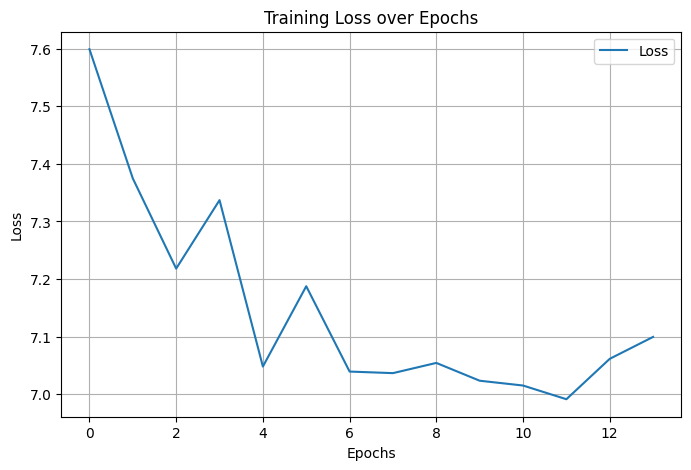

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics["loss"])), metrics["loss"], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

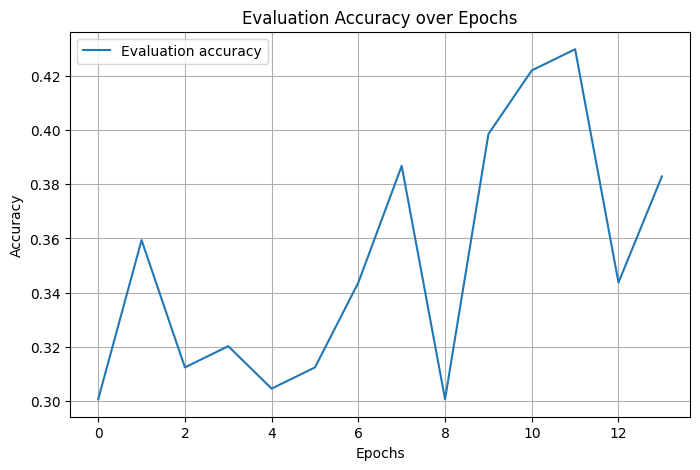

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics["accuracy"])), metrics["accuracy"], label='Evaluation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

In [2]:
# TODO: Comment on instance memorization, task memorization,
# and learning to learn include the plot 

<div style="text-align: center;">
<img src="assets/learning_behavior.png" alt="Meta-learned behavior" width="70%"/>
</div>

To inspect the performance of our model we inspect a single batch from the validation set to see if it is able to infer the correct labels.

In [82]:
# If you desire to take trained weights of epoch 600, run this cell
with open("output/gpicl_e280.pkl", "rb") as f:
    state_dict = pickle.loads(f.read())
    
params = serialization.from_state_dict(params, state_dict)
state = TrainState.create(
    apply_fn=vit_model.apply,
    params=params,
    tx=optax.adamw(learning_rate=lr)
)

In [83]:
val_dataset = FewShotDataset(dataset=MNIST, train=False)
val_data_loader = DataLoader(val_dataset, batch_sampler=FewShotBatchSampler(val_dataset.y, n_way, k_shot))

X, y = next(iter(val_data_loader))
X, y= X.numpy(), y.numpy()

# X, y = augment_tasks(X, y, key) 

# Here we either pass the state.params or the params
# and make the predictions
logits = state.apply_fn(state.params, X, y[:, :-1])
logits.shape

(5, 10)

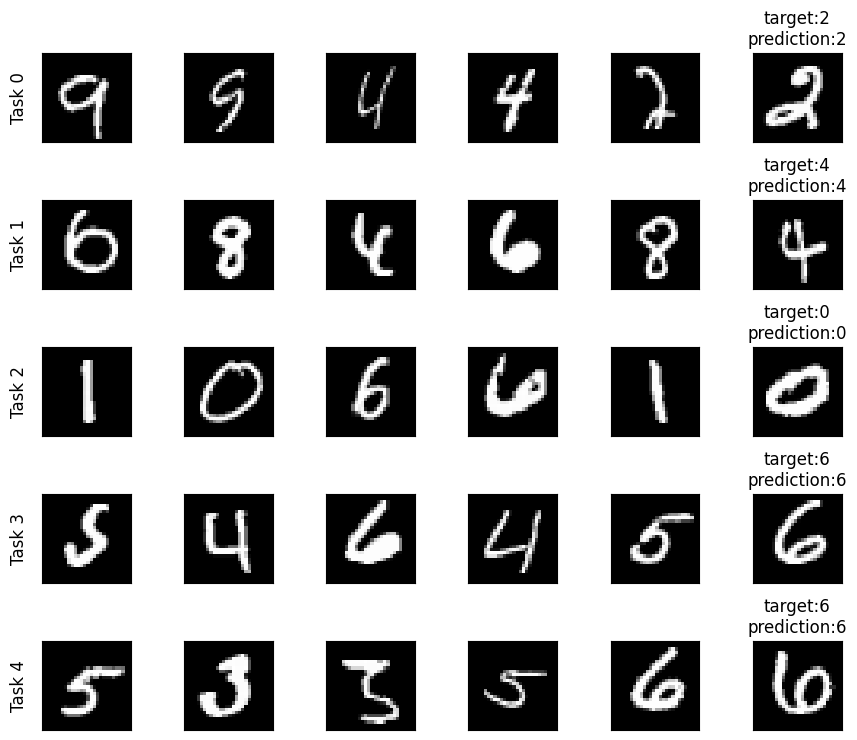

In [84]:
# Visualize the MNIST task with the final prediction on the query
# image.
def visualize_tasks(X, y, y_hat): 
    # X: (B, S, 28, 28), y, (B, C), y_hat: (B)
    B, S = X.shape[:2]

    if len(X.shape) == 3:
        X = X.reshape(*X.shape[:2], 28, 28)
    
    fig, axes = plt.subplots(B, S, figsize=(S*1.5, B*1.5))
    for i in range(B):
        axes[i, 0].set_ylabel(
            f"Task {i}", 
            rotation=90,
            size='large',
            labelpad=10
        )
        for j in range(S):
            ax = axes[i, j]
            ax.imshow(X[i, j], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            if j == S-1:
                ax.set_title(f"target:{int(y[i, -1])}\nprediction:{int(y_hat[i])}")
    
    plt.tight_layout()
    plt.show()

visualize_tasks(X, y, jnp.argmax(logits, axis=-1))

And with the task augmentation as done during training:

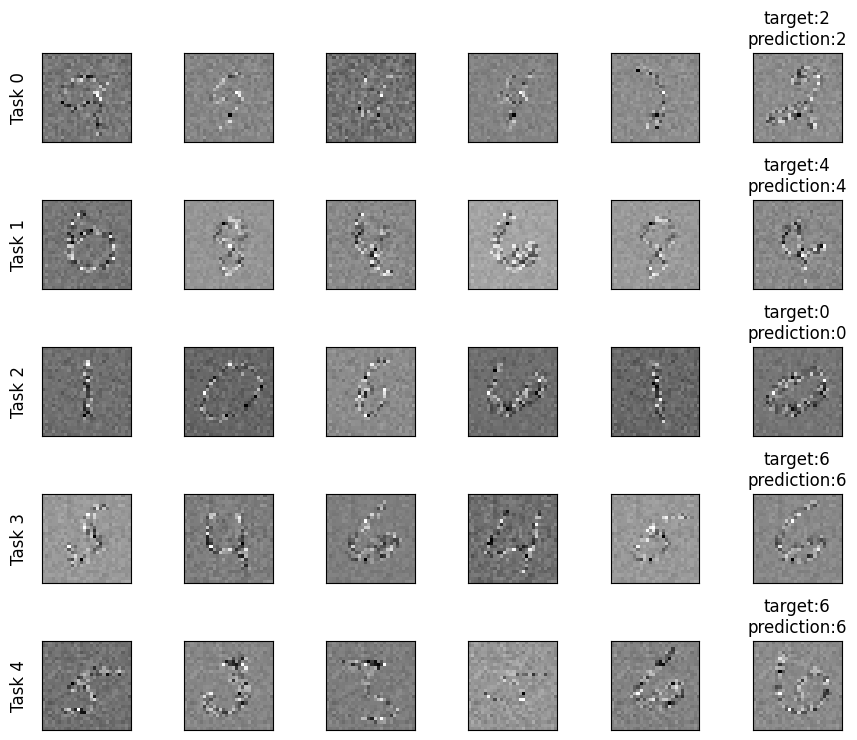

In [85]:
X, y = augment_tasks(X, y, key) 
logits = state.apply_fn(state.params, X, y[:, :-1])
visualize_tasks(X, y, jnp.argmax(logits, axis=-1))

In [5]:
# TODO: Show the performance on the fashionMNIST task, this is the promise of the method

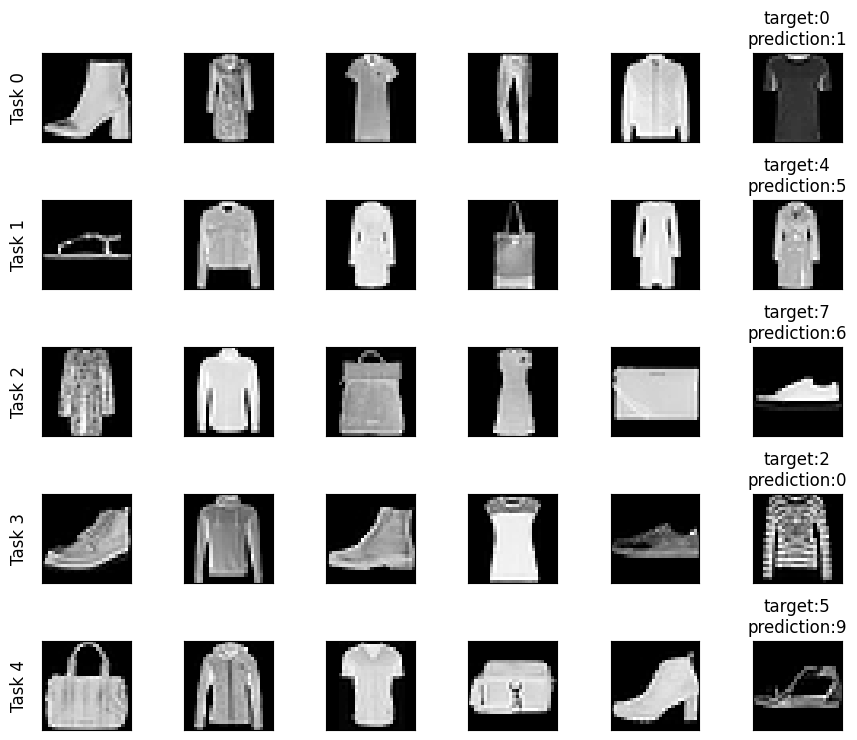

In [86]:
fashion_dataset = FewShotDataset(dataset=FashionMNIST, train=True)
fashion_data_loader = DataLoader(fashion_dataset, batch_sampler=FewShotBatchSampler(val_dataset.y, n_way, k_shot))

X, y = next(iter(fashion_data_loader))
X, y= X.numpy(), y.numpy()

# Here we either pass the state.params or the params
# and make the predictions
logits = state.apply_fn(state.params, X, y[:, :-1])
visualize_tasks(X, y, jnp.argmax(logits, axis=-1))

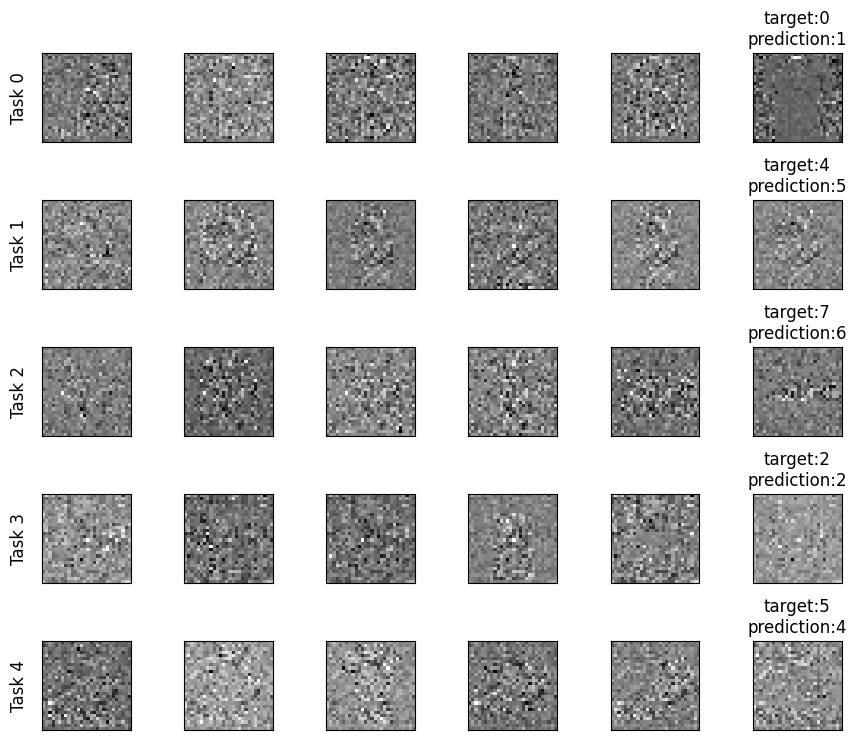

In [88]:
X, y = augment_tasks(X, y, key)
logits = state.apply_fn(state.params, X, y[:, :-1])
visualize_tasks(X, y, jnp.argmax(logits, axis=-1))

In [ ]:
# TODO: Show difference with label permutation model 